# Computer Vision Lecture - Exercise 2 Part 1 - Structure-from-Motion

This first part of exercise 2 contains hands-on coding problems in two-frame structure from motion. More specifically, given a pair of views with known camera intrinsics and matched correspondence points based on SIFT features, we will implement the 8-point algorithm to recover both the fundamental and essential matrix. We will look at both the "vanilla" and the normalized version and compare their robustness to noisy correspondence points. In a next step, we will implement triangulation via the DLT, which you are already familiar with from the previous exercise. With that
we have all the necessary building blocks to recover both the relative pose of the two views and a 3d-reconstruction of the scene.

As in the previous exercise, this notebook guides you through the relevant steps. When you see helper functions, you don't need to do anything - they are already implemented. The functions you need to implement are indicated as Exercise Function and where applicable the sections you need to fill in are marked. Sometimes, you can find Hints - these are written upside-down so you can first try to find the solution without reading them.

Happy hacking!

## Preliminaries

Let's first import relevant libaries, load the images/views along with their calibration data and visualize them.

In [ ]:
#Uncomment below to install dependencies in google colab
!pip install opencv-python==4.5.1.48
!pip install ipympl

import cv2
import json

import numpy as np
import matplotlib.pyplot as plt

# Load images
img1 = cv2.cvtColor(cv2.imread('./img1.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('./img2.jpg'), cv2.COLOR_BGR2RGB)

# Load cameras file
camera_dict = np.load('./cameras.npz')
# camera1
scale_mat1 = camera_dict['scale_mat_%d' % 45].astype(np.float32)
world_mat1 = camera_dict['world_mat_%d' % 45].astype(np.float32)
proj_mat1 = (world_mat1 @ scale_mat1)[:3, :4]
K1 = cv2.decomposeProjectionMatrix(proj_mat1)[0]
K1 = K1/K1[2, 2]
# camera2
scale_mat2 = camera_dict['scale_mat_%d' % 41].astype(np.float32)
world_mat2 = camera_dict['world_mat_%d' % 41].astype(np.float32)
proj_mat2 = (world_mat2 @ scale_mat2)[:3, :4]
K2 = cv2.decomposeProjectionMatrix(proj_mat2)[0]
K2 = K2/K2[2, 2]

# Let's visualize the images
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.imshow(img1)
ax2.imshow(img2)
plt.show()

Next, we need to find correspondence points for the two views. For this we provide a helper function which first finds salient points using SIFT and then performs k-nearest neighbour matching based on these SIFT features. To remove outliers we perform the ratio test. SIFT is just one of many descriptors implemented in OpenCV - feel free to try some others and also play around with the ratio parameter for outlier removal. Once computed, we can visualize the matches.

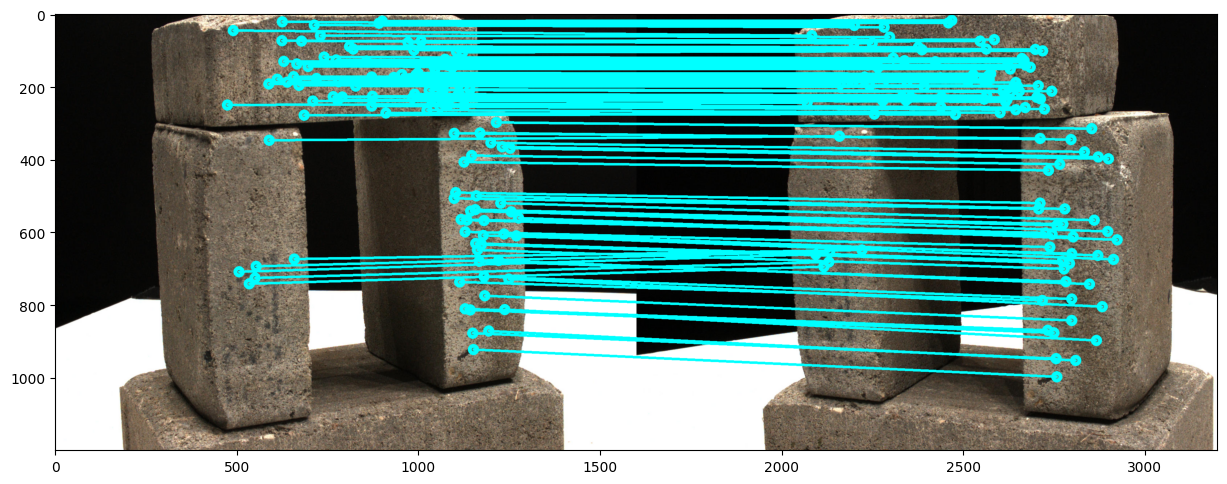

In [4]:
###########################
##### Helper Function #####
###########################
def get_keypoints(img1, img2):
    ''' 
    Finds correspondence points between two images by searching for salient 
    points via SIFT and then searching for matches via k-nearest neighours.
    Performs a ratio test to filter for outliers.
    
    Args:
        img1 (np.ndarray): image, first view
        img2 (np.ndarray): image, second view
    Returns:
        p_source(np.ndarray): Nx3 array of correspondence points in first view
            in homogenous image coordinates.
        p_source(np.ndarray): Nx3 array of correspondence points in second view
            in homogenous image coordinates.
    '''
    # Initialize feature description algorithm
    # We are going to use SIFT but OpenCV provides 
    # implementations for many more - feel free to try them!
    descriptor = cv2.SIFT_create(nfeatures=10000)

    keypoints1, features1 = descriptor.detectAndCompute(img1, None)
    keypoints2, features2 = descriptor.detectAndCompute(img2, None)
    
    # Initialize matching algorithm
    # We are going to use k-nearest neighbours with L2 as the distance measure
    bf = cv2.BFMatcher_create(cv2.NORM_L2)

    # Find matching points
    matches = bf.knnMatch(features1, features2, k=2)
    
    # Remove outliers via ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good.append(m)

    # Select matched points
    keypoints1 = np.float32(
        [ keypoints1[good_match.queryIdx].pt for good_match in good ]
    ).reshape(-1,2)
    keypoints2 = np.float32(
        [ keypoints2[good_match.trainIdx].pt for good_match in good ]
    ).reshape(-1,2)

    # Augment point vectors
    N = keypoints1.shape[0]
    keypoints1 = np.concatenate([keypoints1, np.ones((N, 1))], axis=-1)
    keypoints2 = np.concatenate([keypoints2, np.ones((N, 1))], axis=-1)

    return keypoints1, keypoints2

###########################
##### Helper Function #####
###########################
def draw_matches(img1, img2, keypoints1, keypoints2):
    ''' 
    Returns a visualization of correspondences accross two images.

    Args:
        img1 (np.ndarray): image, first view
        img2 (np.ndarray): image, second view
        keypoints1 (np.ndarray): Nx3 array of correspondence points in first 
            view in homogenous image coordinates.
        keypoints2 (np.ndarray): Nx3 array of correspondence points in second 
            view in homogenous image coordinates.

    Returns:
        output_img (np.ndarray): image, horizontally stacked first and sedond
        view with correspondence points overlaid.    
    '''
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # stack views horizontally
    output_img = np.zeros((max([h1, h2]), w1 + w2, 3), dtype='uint8')
    output_img[:h1, :w1, :] = np.dstack([img1])
    output_img[:h2, w1:w1 + w2, :] = np.dstack([img2])

    # draw correspondences
    # we only visualize only a subset for clarity
    for p1, p2 in zip(keypoints1[::4], keypoints2[::4]):
        (x1, y1) = p1[:2]
        (x2, y2) = p2[:2]

        cv2.circle(output_img, (int(x1), int(y1)), 10, (0, 255, 255), 10)
        cv2.circle(output_img, (int(x2) + w1, int(y2)), 10, (0, 255, 255), 10)

        cv2.line(output_img, (int(x1), int(y1)), (int(x2) + w1, int(y2)), (0, 255, 255), 5)

    return output_img

# compute and visualize correspondences
keypoints1, keypoints2 = get_keypoints(img1, img2)
correspondence_vis = draw_matches(img1, img2, keypoints1, keypoints2)
fig = plt.figure(figsize=(15,10))
plt.imshow(correspondence_vis)
plt.show()

## The 8-Point Algorithm

Now that we have sensible correspondence points we can begin recovering some geometry.

### Exercise function 1

In the skeleton below, implement the standard version of the 8-point algorithm (no normalization) to compute the fundamental matrix from a set of corresponding points in homogenous image coordinates.

*Hint 1*: ˙suoᴉʇɔǝɹᴉp ʎɐɹ lɐɔol ɟo pɐǝʇsuᴉ sǝʇɐuᴉpɹooɔ ǝƃɐɯᴉ ɯoɹɟ punoɟ ʇsnɾ 'ǝɹnʇɔǝl ǝɥʇ uᴉ uʍoɥs sɐ xᴉɹʇɐɯ lɐᴉʇuǝssǝ ǝɥʇ ɹoɟ sɐ ǝɯɐs ǝɥʇ sʞool ɯǝʇsʎs ɹɐǝuᴉl ǝɥ┴

In [14]:
###########################
#### Exercise Function ####
###########################
def compute_fundamental_matrix(keypoints1, keypoints2):
    ''' 
    Computes the fundamental matrix from image coordinates using the 8-point 
    algorithm by constructing and solving the corresponding linear system.

    Args:
        keypoints1 (np.ndarray): Nx3 array of correspondence points in first 
            view in homogenous image coordinates.
        keypoints2 (np.ndarray): Nx3 array of correspondence points in second 
            view in homogenous image coordinates.

    Returns:
        F (np.ndarray): 3x3 fundamental matrix.
    '''
    #######################################
    # -------------------------------------
    # TODO: ENTER CODE HERE (EXERCISE 1)
    # -------------------------------------
    point_cnt = keypoints1.shape[0]
    assert(point_cnt > 8)
    
    A = np.zeros([point_cnt, 9])
    
    for i in range(point_cnt):
        A[i] = [
            #row 1
            keypoints1[i,0] * keypoints2[i, 0],
            keypoints1[i,1] * keypoints2[i, 0],
            keypoints2[i,0],
            #row2
            keypoints1[i,0] * keypoints2[i, 1],
            keypoints1[i,1] * keypoints2[i, 1],
            keypoints2[i,1],
            #row3    
            keypoints1[i,0],
            keypoints2[i,1],
            1,
            ]
    #now we have the entire A
    U, S, V = np.linalg.svd(A)
    F = V[-1].reshape(3,3)
    
    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = U @ (np.diag(S) @ V)
    return F/F[2,2]


Let's look at our result by visualizing the epipolar lines. How can we tell if the result is sensible?

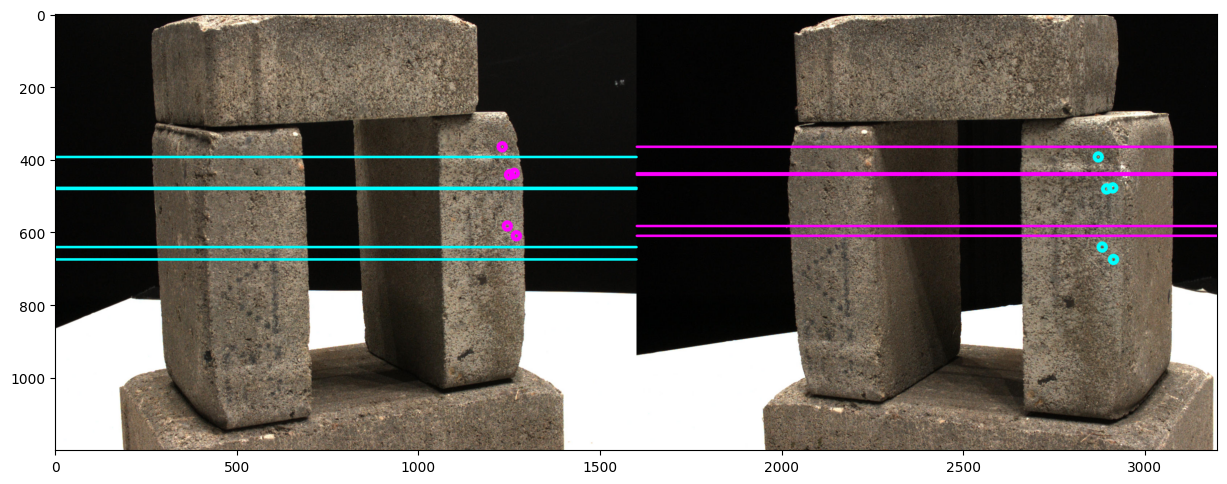

In [19]:
# Compute fundamental matrix using 8-point algorithm
F = compute_fundamental_matrix(keypoints1, keypoints2)

# Compute epipolar lines
el2 = np.swapaxes(F @ keypoints1.swapaxes(0, 1), 0, 1)
el1 = np.swapaxes(F.transpose() @ keypoints2.swapaxes(0, 1), 0, 1)


###########################
##### Helper Function #####
###########################
def draw_epipolar_lines(img1, img2, els1, els2, kps1, kps2):
    ''' 
    Returns an image with epipolar lines drawn onto the images.

    Args:
        img1 (np.ndarray): image, first view
        img2 (np.ndarray): image, second view
        els1 (np.ndarray): Nx3 array of epipolar lines in the first view 
            induced by correspondences in the second view.
        els2 (np.ndarray): Nx3 array of epipolar lines in the second view 
            induced by correspondences in the first view.    
        keypoints1 (np.ndarray): Nx3 array of correspondence points in first 
            view in homogenous image coordinates.
        keypoints2 (np.ndarray): Nx3 array of correspondence points in second 
            view in homogenous image coordinates.

    Returns:
        output_img (np.ndarray): image, horizontally stacked first and sedond
        view with correspondence points overlaid.
    '''
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    output_img = np.zeros((max([h1, h2]), w1 + w2, 3), dtype='uint8')
    output_img[:h1, :w1, :] = np.dstack([img1])
    output_img[:h2, w1:w1 + w2, :] = np.dstack([img2])

    for p1, el1, p2, el2 in zip(kps1, els1, kps2, els2):
        (x1, y1) = p1[:2]
        (x2, y2) = p2[:2]

        el1_x_0, el1_y_0 = map(int, [0, -el1[2]/el1[1]])
        el1_x_1, el1_y_1 = map(
            int, [w1, (-el1[0] / el1[1]) * w1 - el1[2]/el1[1]]
        )
        el2_x_0, el2_y_0 = map(int, [0, -el2[2]/el2[1]])
        el2_x_1, el2_y_1 = map(
            int, [w2, (-el2[0] / el2[1]) * w2 - el2[2]/el2[1]]
        )

        cv2.circle(output_img, (int(x1), int(y1)), 10, (255, 0, 255), 10)
        cv2.circle(output_img, (int(x2) + w1, int(y2)), 10, (0, 255, 255), 10)

        cv2.line(output_img, (el1_x_0, el1_y_0), (el1_x_1, el1_y_1), (0, 255, 255), 5)
        cv2.line(output_img, (el2_x_0 + w1, el2_y_0), (el2_x_1 + w1, el2_y_1), (255, 0, 255), 5)

    return output_img

# Plot epipolar lines
el_vis = draw_epipolar_lines(
    img1, img2, el1[0:5], el2[0:5], keypoints1[0:5], keypoints2[0:5]
)
fig = plt.figure(figsize=(15, 10))
plt.imshow(el_vis)
plt.show()

In this case we have fairly accurate correspondences, so the standard 8-point algorithm already works. But, as you know from lecture 3, the multiplicative measurement terms in our system of equations make the standard version of the algorihtm sensitive to measurement noise. Let's add some artificial noise and see how that affects the estimation.

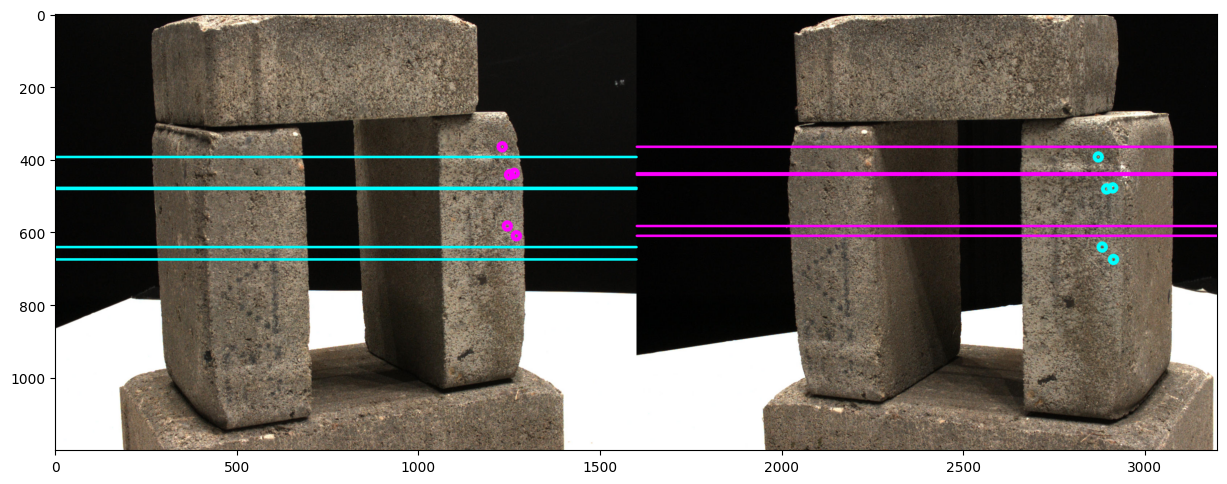

In [20]:
# add noise to correspondences
keypoints_noisy1 = np.copy(keypoints1)
keypoints_noisy2 = np.copy(keypoints2)
keypoints_noisy1[..., :2] += np.random.normal(0, 2, size=keypoints_noisy1[..., :2].shape)
keypoints_noisy2[..., :2] += np.random.normal(0, 2, size=keypoints_noisy2[..., :2].shape)

F = compute_fundamental_matrix(
    keypoints_noisy1,
    keypoints_noisy2
)

# Compute epipolar lines
el2 = np.swapaxes(F @ keypoints1.swapaxes(0, 1), 0, 1)
el1 = np.swapaxes(F.transpose() @ keypoints2.swapaxes(0, 1), 0, 1)

# Plot epipolar lines
el_vis = draw_epipolar_lines(
    img1, img2, el1[0:5], el2[0:5], keypoints1[0:5], keypoints2[0:5]
)
fig = plt.figure(figsize=(15, 10))
plt.imshow(el_vis)
plt.show()

Oops! Luckily, we can make this algorithm more robust with just a few lines of code: 1.) We first normalize the correspondence points to zero-mean and unit variance, 2.) run the 8-point algorithm on these normalized points and 3.) finally back-transform the resulting fundamental matrix. This is the normalized 8-point algorithm described in "In Defense of the 8-Point Algorithm" (Hartley, TPAMI, 1997).

### Exercise Function 2
Implement this algorithm in the following function skeleton. You can reuse exercise function 1.

In [ ]:
###########################
#### Exercise Function ####
###########################
def compute_fundamental_matrix_normalized(keypoints1, keypoints2):
    ''' 
    Computes the fundamental matrix from image coordinates using the normalized
    8-point algorithm by first normalizing the keypoint coordinates to zero-mean 
    and unit variance, then constructing and solving the corresponding linear 
    system and finally undoing the normaliziation by back-transforming the 
    resulting matrix.

    Args:
        keypoints1 (np.ndarray): Nx3 array of correspondence points in first 
            view in homogenous image coordinates.
        keypoints2 (np.ndarray): Nx3 array of correspondence points in second 
            view in homogenous image coordinates.

    Returns:
        F (np.ndarray): 3x3 fundamental matrix.
    '''
    #######################################
    # -------------------------------------
    # TODO: ENTER CODE HERE (EXERCISE 2)
    # -------------------------------------
    #first get the central points of 2 point sets
    center1 = np.mean(keypoints1, axis = 0)
    center2 = np.mean(keypoints2, axis = 1)
    
    #get scale
    scale1 = np.sqrt(2.) / np.mean(np.linalg.norm(keypoints1 - center1, axis = 1))
    scale1 = np.sqrt(2.) / np.mean(np.linalg.norm(keypoints2 - center2, axis = 1))
    
    
    
    return F

Let's compare both variants of the algorithm:

In [ ]:
# Compute F from noisy correspondences using normalized 8-point algorithm
F_normalized = compute_fundamental_matrix_normalized(
    keypoints_noisy1,
    keypoints_noisy2
)

el2_normalized = np.swapaxes(F_normalized @ keypoints1.swapaxes(0, 1), 0, 1)
el1_normalized = np.swapaxes(F_normalized.transpose() @ keypoints2.swapaxes(0, 1), 0, 1)

el_vis_normalized = draw_epipolar_lines(
    img1, img2, 
    el1_normalized[0:5], el2_normalized[0:5], 
    keypoints1[0:5], keypoints2[0:5]
)
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.imshow(el_vis)
ax2.imshow(el_vis_normalized)
plt.show()

# For the following sections we recompute F without artificial noise
F_normalized = compute_fundamental_matrix_normalized(keypoints1, keypoints2)

### Exercise Function 3
Given this robust estimation of the fundamental matrix and the intrinsics for both cameras/views we can compute the essential matrix. Implement this in the skeleton below.

In [ ]:
###########################
#### Exercise Function ####
###########################
def compute_essential_matrix(F, K1, K2):
    ''' 
    Computes the essential from the fundamental matrix given known intrinsics.

    Args:
        F (np.ndarray): 3x3 fundamental matrix.
        K1 (np.ndarray): The 3x3 calibration matrix K for the first 
            view/camera.
        K2 (np.ndarray): The 3x3 calibration matrix K for the second
            view/camera.

    Returns:
        E (np.ndarray): 3x3 essential matrix.
    '''
    #######################################
    # -------------------------------------
    # TODO: ENTER CODE HERE (EXERCISE 3)
    # -------------------------------------
    return E

## Triangulation

Next we decompose the essential matrix to recover the relative pose of the second camera/view with respect to the first one. With this we can reconstruct the scene by triangulating correspondences. Unfortunately, this decomposition yields four possible solutions (See Szeliski book p. 685-686 for details). But, we can find the correct solution by doing triangulation with all of them and selecting the one that results in the highest number of triangulated points that lie in front of both cameras. This is called the chirality check.

### Exercise Function 4
In the skeleton below, implement a function that triangulates a point 'x_w' from its correspondeces in homogenous image coordinates 'x_1^s' and 'x_2^s' using the direct linear transform. You can use the provided helper functions to construct the projection matrix 'P' from intrinsics 'K', Rotation 'R' and translation 't' (see lecture 2) for convenience.

*Hint 1*: ˙ɹoʇɔǝʌ uoᴉʇɐlsuɐɹʇ oɹǝz puɐ xᴉɹʇɐɯ uoᴉʇɐʇoɹ ʎʇᴉʇuǝpᴉ ǝɥʇ oʇ ʇǝs ǝq uɐɔ ɐɹǝɯɐɔ ʇsɹᴉɟ ǝɥʇ ɹoɟ sɔᴉsuᴉɹʇxǝ ǝɥ┴



In [ ]:
# From the essential matrix we can recover the relative rotation and
# translation between views
E = compute_essential_matrix(F_normalized, K1, K2)
R1, R2, t = cv2.decomposeEssentialMat(E)

###########################
##### Helper Function #####
###########################
def assemble_pose_matrix(R, t):
    ''' 
    Builds 4x4 pose matrix (extrinsics) from 3x3 rotation matrix and
    3-d translation vector. See also lecture two.

    Args:
        R (np.ndarray): 3x3 rotation matrix.
        t (np.ndarray): 3-d translation vector.

    Returns:
        pose (np.ndarray): 4x4 pose matrix (extrinsics).
    '''
     # augment R
    R = np.concatenate([R, np.zeros([1, 3])], axis=0)
    
    # augment T
    t = np.concatenate([t, np.ones([1, 1])])

    # assemble and return pose matrix
    return np.concatenate([R, t], axis=1)

###########################
##### Helper Function #####
###########################
def assemble_projection_matrix(K, R, t):
    ''' 
    Builds 3x4 projection matrix from 3x3, calibration matrix, 3x3 rotation 
    matrix and 3-d translation vector. See also lecture two.

    Args:
        K (np.ndarray): 3x3 calibration matrix.
        R (np.ndarray): 3x3 rotation matrix.
        t (np.ndarray): 3-d translation vector.

    Returns:
        P (np.ndarray): 4x4 pose matrix.
    '''
    # TODO: use assemble pose
    # augment K
    K = np.concatenate([K, np.zeros([3, 1])], axis=1)

    # augment R
    R = np.concatenate([R, np.zeros([1, 3])], axis=0)
    
    # augment T
    t = np.concatenate([t, np.ones([1, 1])])

    # assemble and return camera matrix P
    return K @ np.concatenate([R, t], axis=1)

###########################
#### Exercise Function ####
###########################
def triangulate_point(keypoint1, keypoint2, K1, K2, R, t):
    ''' 
    Triangulates world coordinates given correspondences from two views with
    relative extrinsics R and t.

    Args:
        keypoints1 (np.ndarray): Nx3 array of correspondence points in first 
            view in homogenous image coordinates.
        keypoints2 (np.ndarray): Nx3 array of correspondence points in second 
            view in homogenous image coordinates.
        K1 (np.ndarray): The 3x3 calibration matrix K for the first 
            view/camera.
        K2 (np.ndarray): The 3x3 calibration matrix K for the second
            view/camera.
        R (np.ndarray): 3x3 rotation matrix from first to second view.
        t (np.ndarray): 3-d translation vector from first to second view.

    Returns:
        x_w (np.ndarray): Nx4 array of 3-d points in homogenous world 
            coordinates.
    '''
    #######################################
    # -------------------------------------
    # TODO: ENTER CODE HERE (EXERCISE 4)
    # -------------------------------------
    
    return x_w

Let's use this function to do the chirality check and visualize the reconstructed scene as well as the camera/view poses! The resulting figure is interactive, so you can drag it with your mouse cursor to get different vantage points (unfortunately this does *not* work in google colab).

In [ ]:
###########################
##### Helper Function #####
###########################
def chirality_check(keypoints1, keypoint2, K1, K2, R1, R2, t):
    ''' 
    Triangulates world coordinates given correspondences from two views with
    relative extrinsics R and T.

    Args:
        keypoints1 (np.ndarray): Nx3 array of correspondence points in first 
            view in homogenous image coordinates.
        keypoints2 (np.ndarray): Nx3 array of correspondence points in second 
            view in homogenous image coordinates.
        K1 (np.ndarray): The 3x3 calibration matrix K for the first 
            view/camera.
        K2 (np.ndarray): The 3x3 calibration matrix K for the second
            view/camera.
        R1 (np.ndarray): first possible 3x3 rotation matrix from first to 
            second view.
        R2 (np.ndarray): second possible 3x3 rotation matrix from first to 
            second view.
        T (np.ndarray): 3-d translation vector from first to second view.

    Returns:
        pose (tuple of np.ndarrays): 3x3 rotation matrix and 3-d translation
            vector from first to second view.
        x_w (np.ndarray): Nx4 array of 3-d points in homogenous world 
            coordinates.
    '''
    solutions = [(R1, t), (R1, -t), (R2, t), (R2, -t)]
    valid = [0, 0, 0, 0]
    all_triangulations = []
    for i, solution in enumerate(solutions):
        triangulations = []
        for kp1, kp2 in zip(keypoints1, keypoints2):
            # triangulate points with respect to reference camera
            x_w = triangulate_point(
                kp1, kp2, 
                K1, K2,
                solution[0], solution[1],
            )
            triangulations.append(x_w)

            # perform chirality check
            visible = False
            # visibility in reference view
            if x_w[2] > 0 and x_w[2] < 50:
                visible = True
                
            # visibility in other view 
            x_w = assemble_projection_matrix(K1, solution[0], solution[1]) @ x_w

            if x_w[2] > 0 and x_w[2] < 50:
                visible = True
            else:
                visible = False

            # increment number of valid points if visible in both
            if visible:
                valid[i] += 1

        # collect triangulations for all solutions 
        # so we don't have to recompute them
        all_triangulations.append(
            np.array(triangulations, np.float32)
        )

    # return the solution for which the most points are visible in both cameras
    return solutions[np.argmax(valid)], all_triangulations[np.argmax(valid)]

###########################
##### Helper Function #####
###########################
def draw_camera(ax, pose, K):
    ''' 
    Draws a camera coordinate frame in 3d plot. 

    Args:
        ax (matplotlib axes): The figure in which to draw the camera.
        pose (np.ndarray): 4x4 pose matrix (extrinsics).
        K (np.ndarray): 3x3 calibration matrix (intrinsics).

    Returns:
        ax (matplotlib): Figure with camera added.
    '''
    # set up unit vectors
    scale = K[0, 0] / 10000
    o = np.array([0, 0, 0, 1])
    x = np.array([1 * scale , 0, 0, 1])
    y = np.array([0, 1 * scale, 0, 1])
    z = np.array([0, 0, 1 * scale, 1])

    pose = np.linalg.inv(pose)
    o_prime = pose @ o
    x_prime = pose @ x
    y_prime = pose @ y
    z_prime = pose @ z

    ax.plot(
        [o_prime[0], x_prime[0]], [o_prime[2], x_prime[2]],  [-o_prime[1], -x_prime[1]], c='r'
    )
    ax.plot(
        [o_prime[0], y_prime[0]], [o_prime[2], y_prime[2]], [-o_prime[1], -y_prime[1]], c='b'
    )
    ax.plot(
        [o_prime[0], z_prime[0]], [o_prime[2], z_prime[2]], [-o_prime[1], -z_prime[1]], c='g'
    )
    return ax

pose2, triangulations = chirality_check(keypoints1, keypoints2, K1, K2, R1, R2, t)

# Draw results
%matplotlib widget
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(211)
ax1.imshow(draw_matches(img1, img2, [], []))
ax2 = fig.add_subplot(212, projection='3d')
ax2.scatter(
    triangulations[:, 0], 
    triangulations[:, 2], 
    - triangulations[:, 1], 
    c='r', marker='o',
)

P1 = assemble_pose_matrix(np.eye(3), np.zeros([3, 1]))
ax2 = draw_camera(ax2, P1, K1)
P2 = assemble_pose_matrix(pose2[0], pose2[1])
ax2 = draw_camera(ax2, P2, K2)
ax2.set_xlabel('X Axis')
ax2.set_ylabel('Z Axis')
ax2.set_zlabel('Y Axis')
plt.show()

Great! We have reconstructed our first scene! Let's move on to the next part of this exercise: Stereo.